# Velocity and acceleration diagnostics : geographicaly bined histograms

- [ ] 2° bins histograms store in 


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed

import GDP_lib as gdp

from GDP_lib import root_dir

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime='04:00:00')
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.108:8787/status,
Dashboard: http://10.148.0.108:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.108:51248,Workers: 0
Dashboard: http://10.148.0.108:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Import

In [3]:
dl=2.0 

In [4]:
zarr_gps_geohist = os.path.join(root_dir, f"gps_geohist_{dl}.zarr")
zarr_argos_geohist = os.path.join(root_dir, f"argos_geohist_{dl}.zarr")

In [5]:
dsg = xr.open_zarr(zarr_gps_geohist).persist()
dsa = xr.open_zarr(zarr_argos_geohist).persist()

# Functions

In [8]:
def regional_histograms(ds, lon_sel, lat_sel, count_key = 'nb_geobins'):
    ds = ds.sel(lon_bins = lon_sel, lat_bins=lat_sel, method='nearest')
    map_ = xr.ones_like(ds[count_key])
    
    nb_total = ds.nb_geobins.sum()
    l_var = [i for i in list(ds.keys()) if i != count_key]
    dsr = xr.Dataset()
    for l in l_var : 
        dsr[l]= ((ds[l]*ds[count_key]).sum(['lon_bins', 'lat_bins']))/nb_total
    dsr['nb_geobins'] = nb_total
    return dsr, map_



In [182]:
##https://stackoverflow.com/questions/3584805/what-does-the-argument-mean-in-fig-add-subplot111
def geo_plot(dsr_dict, map_dict, hist_keys=['hist_ve', 'hist_vex', 'hist_vn', 'hist_vny','hist_ae', 'hist_aex', 'hist_an', 'hist_any',]):
    n=len(hist_keys)
    keys = list(dsr_dict.keys())
    color = ['red', 'teal', 'lime', 'orange', 'hotpink', 'y', 'g']
    
    
    # Legend Map
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,1, 1, projection=ccrs.PlateCarree(central_longitude=-180))
    ax1.add_feature(cfeature.LAND, zorder=2)
    ax1.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True,)
    for m in range(len(map_dict)):
        mi = map_dict[keys[m]].plot(x='lon_bins', ax=ax1, color = color[m], alpha=0.5, add_colorbar=False, transform=ccrs.PlateCarree())
        
    # Spectra   
    fig = plt.figure(figsize=(15,int(np.ceil(n/2))+1*5))
    for i in range(n) : 
        ax = fig.add_subplot(int(np.ceil(n/2))+1,2,i+1)
        for d in  range(len(keys)) : 
            dsr_dict[keys[d]][hist_keys[i]].plot(ax=ax, color=color[d])
        ax.grid()
        
    # Log Spectra   
    fig = plt.figure(figsize=(15,int(np.ceil(n/2))+1*5))
    for i in range(n) : 
        ax = fig.add_subplot(int(np.ceil(n/2))+1,2,i+1)
        for d in  range(len(keys)) : 
            np.log10(dsr_dict[keys[d]][hist_keys[i]]).plot(ax=ax, color=color[d])
        ax.grid()

# Plot

In [179]:
#Gulf Stream
dsgr_gs = regional_histograms(dsg, np.arange(-70,-65,2), np.arange(28,38,2))
#ACC
dsgr_acc = regional_histograms(dsg, np.arange(50,100,2), np.arange(-60,-35,2))
#South atlantic gyre
dsgr_sag = regional_histograms(dsg, np.arange(-30,0,2), np.arange(-30,-20,2))
#North pacific gyre
dsgr_npg = regional_histograms(dsg, np.arange(-155,-145,2), np.arange(25,40,2))

dsr_dict = {'Gulf Stream' : dsgr_gs[0].compute(), 'ACC' : dsgr_acc[0].compute(), 'South atlantic gyre':dsgr_sag[0].compute(), 'North Pacific gyre':dsgr_npg[0].compute()}
map_dict = {'Gulf Stream' : dsgr_gs[1].compute(), 'ACC' : dsgr_acc[1].compute(), 'South atlantic gyre':dsgr_sag[1].compute(), 'North Pacific gyre':dsgr_npg[1].compute()}


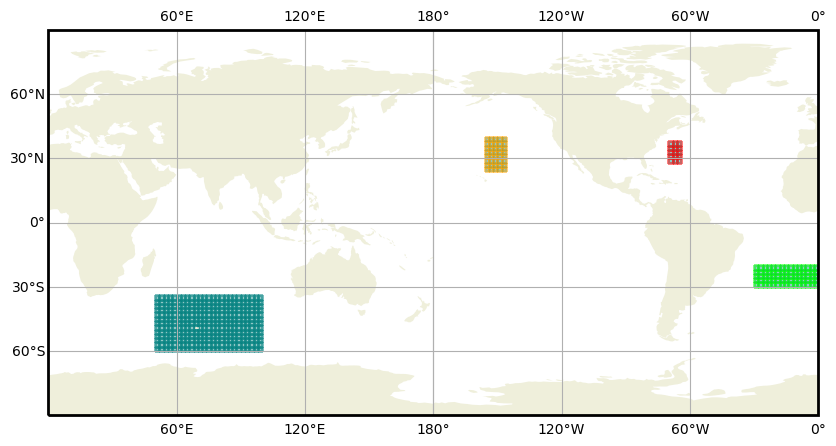

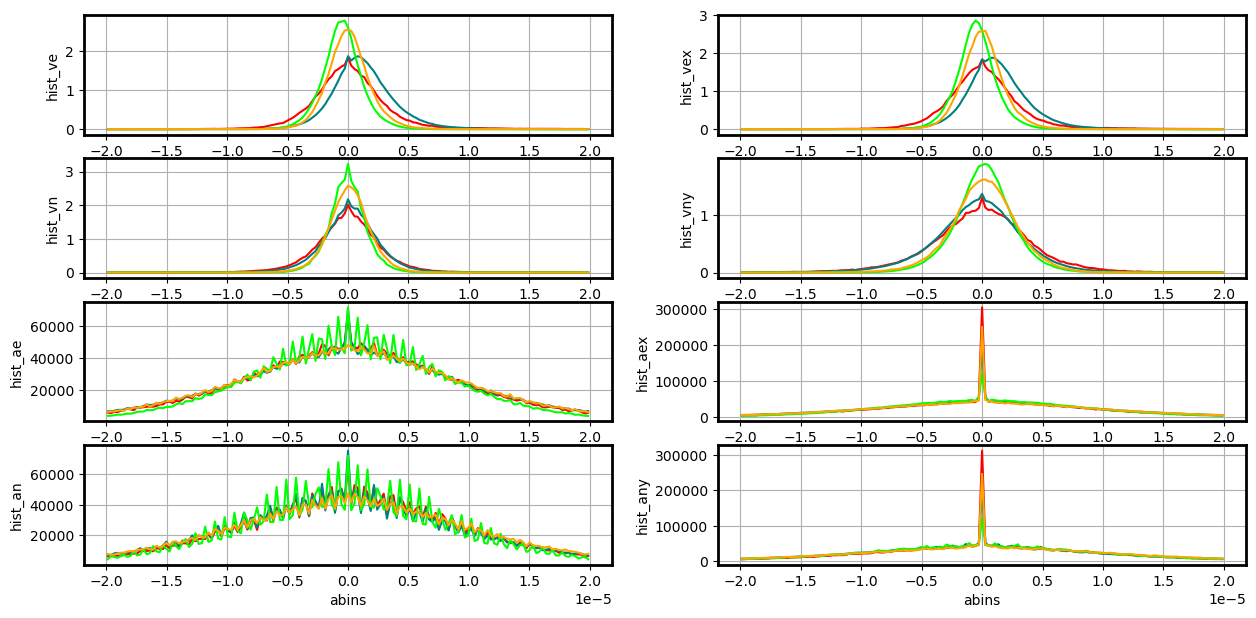

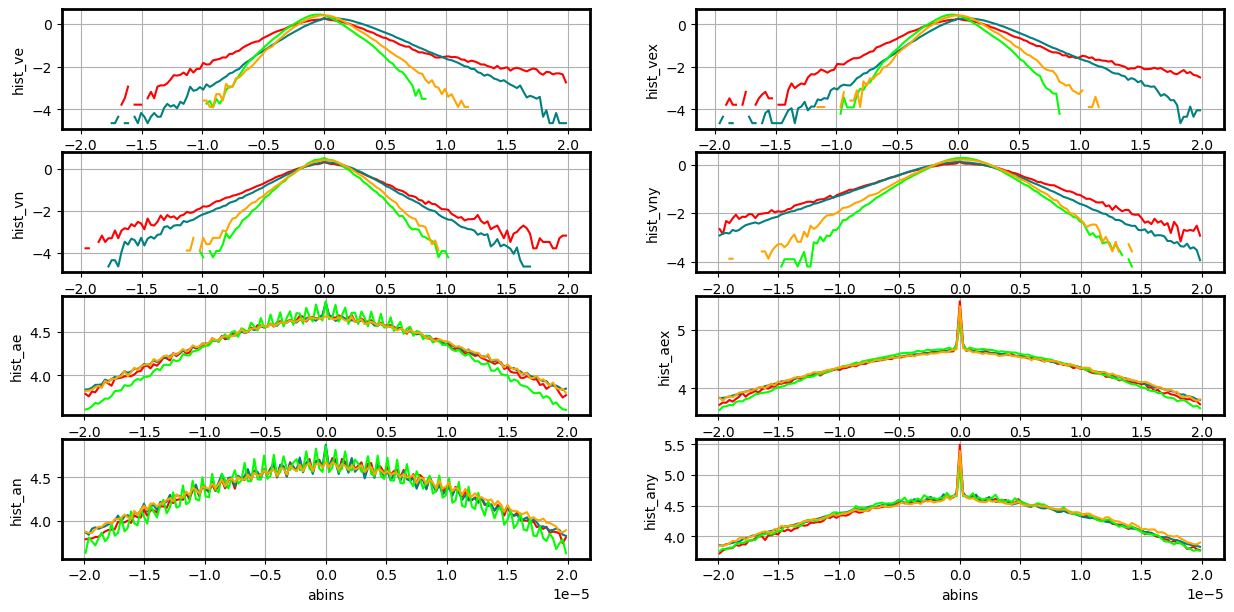

In [183]:
geo_plot(dsr_dict, map_dict)

In [184]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
